In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
from skimage import io, color
import cv2

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = './images/'

In [6]:
files = os.listdir(PATH)

In [7]:
def normalize_data(data):
    data = data / 128
    return data

In [8]:
from PIL import Image
from skimage import io, color
import cv2

inception_images = []
fusion_images = []
lab_a = []
lab_b = []
lab_l = []

def transform_image(image, size=299, output_channels=3):
    trans = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.Grayscale(num_output_channels=output_channels),
    transforms.ToTensor()
])
    return trans(image)

def get_lab(image):
    trans = transforms.CenterCrop(224)
    lab = color.rgb2lab(np.array(trans(image))/255)
    L, a, b = cv2.split(lab)
    return (L, a, b)

for file in files[:200]:
    
    im = Image.open(PATH + file)
    fusion_images.append(transform_image(im, size=224, output_channels=1))
    inception_images.append(transform_image(im))
    L, a, b = get_lab(im)
    lab_l.append(L)
    lab_a.append(a)
    lab_b.append(b)

lab_a = normalize_data(np.array(lab_a, dtype=int))  
lab_b = normalize_data(np.array(lab_b, dtype=int))

In [9]:
fusion_images = torch.stack(fusion_images)
inception_images = torch.stack(inception_images)

In [10]:
ab = torch.cat([torch.Tensor(lab_a).unsqueeze(1), torch.Tensor(lab_b).unsqueeze(1)], dim=1)

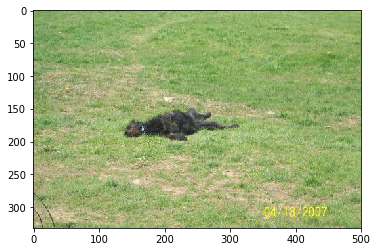

In [11]:
plt.imshow(im)

In [12]:
class imagedata(Dataset):
    
    def __init__(self):
        super().__init__()
        self.inception_images = inception_images
        self.fusion_images = fusion_images
        self.y_data = ab
        self.len = len(self.inception_images)
        
    def __getitem__(self, index):
        return self.inception_images[index], self.fusion_images[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
    

In [13]:
batch_size = 20
imageset = imagedata()
train_loader = torch.utils.data.DataLoader(imageset, batch_size=batch_size)

In [14]:
model_inception = models.inception_v3(pretrained=True).cuda()
model_inception.transform_input = False
model_inception.eval();
for param in model_inception.parameters():
    param.requires_grad = False

In [15]:
def multiply_features(features):

    feature_mult = []

    for i in range(batch_size):
        repeat = features[i].repeat(28 * 28)
        x = repeat.view(28, 28, 1000).transpose(1, 2).transpose(0,1)
        feature_mult.append(x)

    features_mult = torch.stack(feature_mult)
    #features_mult = features_mult.cuda()
    
    return features_mult

In [16]:
class fusion_model(nn.Module):
    
    def __init__(self):
        super(fusion_model, self).__init__()        
        
        sizes = [64, 128, 128, 256, 256, 512, 512,  256]
        s_modules = [nn.Sequential(nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),\
                                   nn.ReLU(inplace=True), nn.BatchNorm2d(64))]
        
        for i in range(len(sizes) - 1):
            s = 2 if i in [1,3] else 1
            s_modules.extend(nn.Sequential(nn.Conv2d(sizes[i], sizes[i + 1], kernel_size=3, stride=s, padding=1),\
                                           nn.ReLU(inplace=True), nn.BatchNorm2d(sizes[i + 1])))
        
        self.encoder = nn.Sequential(*s_modules)
        
        e_modules = [nn.Conv2d(1256, 256, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(256)]
        sizes = [256,128,64,64,32]
        
        for i in range(len(sizes) - 1):
            e_modules.extend(nn.Sequential(nn.Conv2d(sizes[i], sizes[i + 1], kernel_size=3, stride=1, padding=1),\
                                           nn.ReLU(inplace=True), nn.BatchNorm2d(sizes[i + 1])))
            if i in [0,2]:
                e_modules.extend(nn.Sequential(nn.Upsample(scale_factor=2)))
        
        self.decoder = nn.Sequential(*e_modules)
        
        
        self.out = nn.Sequential(nn.Conv2d(32,2,kernel_size=3,stride=1,padding=1), nn.Upsample(scale_factor=2))
        self.up = nn.Upsample(scale_factor=2)
        
    
    def forward(self, x, x_incept):
        x = self.encoder(x)
        incept = model_inception(x_incept)
        x = torch.cat([x, multiply_features(incept)], dim=1)
        x = self.expand(x)
        x = self.up(F.tanh(self.out(x)))

        return x
            

In [17]:
model=fusion_model()
model.cuda();

In [22]:
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [23]:
def train(epochs):
    count = 0
    for epoch in range(epochs):
        
        for i, (inception_images, fusion_images, target) in enumerate(train_loader):

            target = target.cuda()
            
            inception_images = torch.autograd.Variable(inception_images).cuda()
            fusion_images = torch.autograd.Variable(fusion_images).cuda()
           
            result = model(fusion_images, inception_images)
            loss = criterion(result, target)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            print('Epoch {}: batch {} : Loss = {}'.format(epoch + 1, i, loss.data[0]), end='\r')


In [24]:
train(20)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [25]:
def create_images(colours, ix):
    
    lab_images = []
    pos = ix * colours.size(0)
    for i in range(colours.size(0)):
        a = np.array(colours[i][0].cpu()) * 128
        b = np.array(colours[i][1].cpu()) * 128
        lab = np.zeros([224, 224, 3])
        lab[:, :, 0] = lab_l[i + pos]
        lab[:, :, 1] = a
        lab[:, :, 2] = b
        lab_images.append(lab)
    
    return lab_images

In [30]:
for i, (inception_images, fusion_images, target) in enumerate(train_loader):
    
    inception_images = torch.autograd.Variable(inception_images).cuda()
    fusion_images = torch.autograd.Variable(fusion_images).cuda()
           
    result = model(fusion_images, inception_images)
    
    ims = create_images(result.data, i)
    if i == 3:
        break

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
for i in range(len(ims)):
    plt.imshow(color.lab2rgb(ims[i]))
    plt.show()